# MRS Pipeline

**Use case:** Extract spatial-spectral features from IFU cube and measure their attributes.<br>
**Data:** Simulated [MIRI MRS](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-observing-modes/miri-medium-resolution-spectroscopy) spectrum of AGB star.<br>
**Tools:** specutils, jwst, photutils, astropy, aplpy, scipy.<br>
**Cross-intrument:** NIRSpec, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/dat_pyinthesky/tree/main/jdat_notebooks/MRS_Mstar_analysis) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>
**Source of Simulations:** [MIRISim](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim)<br>
**Pipeline Version:** [JWST Pipeline](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline)<br>

**Note**: This notebook includes MIRI simulated data cubes obtained using MIRISim (https://wiki.miricle.org//bin/view/Public/MIRISim_Public)
and run through the JWST pipeline (https://jwst-pipeline.readthedocs.io/en/latest/) of
point sources with spectra representative of late M type stars.

## Introduction

This notebook analyzes one star represented by a dusty SED corresponding to the ISO SWS spectrum of
W Per from Kraemer et al. (2002) and Sloan et al. (2003) to cover the MRS spectral range 5-28 microns.  Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their attributes.

This is the first notebook, which will process the data and automatically detect and extract spectra for the point source.  The workflow will use `photutils` to automatically detect sources in the cube to extract the spectrum of the point source. Then it will read in the spectra generated at Stage 3 of the JWST pipeline.


## Import Packages

In [1]:
# Import useful python packages
import numpy as np

# Import packages to display images inline in the notebook
import matplotlib.pyplot as plt    
%matplotlib inline   

# Set general plotting options
params = {'legend.fontsize': '18', 'axes.labelsize': '18', 
         'axes.titlesize': '18', 'xtick.labelsize': '18', 
         'ytick.labelsize': '18', 'lines.linewidth': 2, 'axes.linewidth': 2, 'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Import astropy packages 
from astropy import units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty
from astropy.io import fits # added by BAS on 8 April 2021
from astropy.utils.data import get_pkg_data_filename

# To find stars in the MRS spectralcubes and do aperture photometry
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder

# To deal with 1D spectrum
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion
from specutils import SpectrumList

# To fit a curve to the data
from scipy.optimize import curve_fit

import os

## Set paths to the Data and Outputs

Use MIRISim JWST pipeline processed data in future iterations.

In [4]:
os.environ['CRDS_PATH'] = os.environ['HOME']+'/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds-pub.stsci.edu'

In [5]:
# import pipeline

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
from jwst.extract_1d import Extract1dStep
import json
import glob
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import crds
from jdaviz.app import Application
import asdf
from photutils import aperture_photometry
import os

In [6]:
# Download data if you don't already have it.

import urllib.request

if os.path.exists("20210413_120546_mirisim.tar.gz"):
    print("20210413_120546_mirisim.tar.gz Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_120546_mirisim.tar.gz'
    urllib.request.urlretrieve(url, './20210413_120546_mirisim.tar.gz')
    
if os.path.exists("20210413_123047_mirisim.tar.gz"):
    print("20210413_123047_mirisim.tar.gz Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_123047_mirisim.tar.gz'
    urllib.request.urlretrieve(url, './20210413_123047_mirisim.tar.gz')
    
if os.path.exists("20210413_125354_mirisim.tar.gz"):
    print("20210413_125354_mirisim.tar.gz Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_125354_mirisim.tar.gz'
    urllib.request.urlretrieve(url, './20210413_125354_mirisim.tar.gz')

In [7]:
# Unzip Tar Files

import tarfile

# Unzip files if they haven't already been unzipped
if os.path.exists("20210413_120546_mirisim/"):
    print("20210413_120546_mirisim Exists")
else:
    tar = tarfile.open('./20210413_120546_mirisim.tar.gz', "r:gz")
    tar.extractall()
    tar.close()
    
if os.path.exists("20210413_123047_mirisim/"):
    print("20210413_123047_mirisim Exists")
else:
    tar = tarfile.open('./20210413_123047_mirisim.tar.gz', "r:gz")
    tar.extractall()
    tar.close()
    
if os.path.exists("20210413_125354_mirisim/"):
    print("20210413_125354_mirisim Exists")
else:
    tar = tarfile.open('./20210413_125354_mirisim.tar.gz', "r:gz")
    tar.extractall()
    tar.close()

## Run Pipeline

The various [stages of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html#pipelines) can be [run within Python](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html#running-from-within-python).  For a more in depth tutorial on running the pipelines, check out the [JWebbinars](https://www.stsci.edu/jwst/science-execution/jwebbinars).

In [8]:
# Execute calwebb_detector1 pipeline on raw simulation output.  This will overwrite previous reductions.

allshortfiles = glob.glob('20210413_*_mirisim/det_images/*MIRIFUSHORT*fits')
alllongfiles = glob.glob('20210413_*_mirisim/det_images/*MIRIFULONG*fits')
      
pipe1short = Detector1Pipeline()

# run calwebb_detector1 on the MIRIFUSHORT data separate from MIRIFULONG data, as it saves time this way
for shortfile in allshortfiles:
    print(shortfile)
    baseshort, remaindershort = shortfile.split('.')
    
    # If you run your own simulations, you will need to update these hardcoded files.
    beforestuffshort, dateafterstuffshort = shortfile.split('20210413_')    
    datestringshort, afterstuffshort = dateafterstuffshort.split('_mirisim')
    
    pipe1short.refpix.skip = True
    pipe1short.output_file = baseshort + datestringshort
    
    pipe1short.run(shortfile)

pipe1long = Detector1Pipeline()

for longfile in alllongfiles:
    print(longfile)
    baselong, remainderlong = longfile.split('.')
    
    # If you run your own simulations, you will need to update these hardcoded files.
    beforestufflong, dateafterstufflong = longfile.split('20210413_')
    datestringlong, afterstufflong = dateafterstufflong.split('_mirisim')
    
    pipe1long.refpix.skip = True
    pipe1long.output_file = baselong + datestringlong
    
    pipe1long.run(longfile)

20210413_120546_mirisim/det_images/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits


2023-09-20 19:09:07,408 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 179 files) (0 / 578.7 K bytes)
2023-09-20 19:09:07,667 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_calver_0031.rmap    3.8 K bytes  (2 / 179 files) (694 / 578.7 K bytes)
2023-09-20 19:09:07,887 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_0030.imap      385 bytes  (3 / 179 files) (4.5 K / 578.7 K bytes)
2023-09-20 19:09:08,150 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0020.rmap    1.5 K bytes  (4 / 179 files) (4.9 K / 578.7 K bytes)
2023-09-20 19:09:08,353 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 179 files) (6.4 K / 578.7 K bytes)
2023-09-20 19:09:08,537 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_superbias_0052.rmap   29.8 

20210413_120546_mirisim/det_images/det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits
20210413_120546_mirisim/det_images/det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits
20210413_120546_mirisim/det_images/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits
20210413_125354_mirisim/det_images/det_image_seq3_MIRIFUSHORT_12LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq2_MIRIFUSHORT_12LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq1_MIRIFUSHORT_12LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq4_MIRIFUSHORT_12LONGexp1.fits
20210413_123047_mirisim/det_images/det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_120546_mirisim/det_images/det_image_seq4_MIRIFULONG_34SHORTexp1.fits


2023-09-20 19:21:37,720 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits  773.6 M bytes  (1 / 7 files) (0 / 842.4 M bytes)
2023-09-20 19:21:49,888 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits    4.2 M bytes  (2 / 7 files) (773.6 M / 842.4 M bytes)
2023-09-20 19:21:50,591 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits   46.5 M bytes  (3 / 7 files) (777.8 M / 842.4 M bytes)
2023-09-20 19:21:51,763 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_mask_0029.fits    4.3 M bytes  (4 / 7 files) (824.4 M / 842.4 M bytes)
2023-09-20 19:21:52,376 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_readnoise_0064.fits    4.2 M bytes  (5 / 7 files) (828.6 M / 842.4 M bytes)
2023-09-20 19:21:52,876 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_rscd_

20210413_120546_mirisim/det_images/det_image_seq2_MIRIFULONG_34SHORTexp1.fits
20210413_120546_mirisim/det_images/det_image_seq1_MIRIFULONG_34SHORTexp1.fits
20210413_120546_mirisim/det_images/det_image_seq3_MIRIFULONG_34SHORTexp1.fits
20210413_125354_mirisim/det_images/det_image_seq4_MIRIFULONG_34LONGexp1.fits


2023-09-20 19:26:00,971 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits   46.5 M bytes  (1 / 1 files) (0 / 46.5 M bytes)


20210413_125354_mirisim/det_images/det_image_seq3_MIRIFULONG_34LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq2_MIRIFULONG_34LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq1_MIRIFULONG_34LONGexp1.fits
20210413_123047_mirisim/det_images/det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits


2023-09-20 19:30:02,390 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits   46.5 M bytes  (1 / 1 files) (0 / 46.5 M bytes)


20210413_123047_mirisim/det_images/det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits


In [9]:
# Execute calwebb_spec2 pipeline. This will overwrite previous reductions.

# All the local calwebb_detector1 files
allshortfiles2 = glob.glob('det_image_*_MIRIFUSHORT_*_rate.fits')
alllongfiles2 = glob.glob('det_image_*_MIRIFULONG_*_rate.fits')

for short2file in allshortfiles2:
    print(short2file)
    pipe2short = Spec2Pipeline()
    base2short, remainder2short = short2file.split('.')
    
    pipe2short.straylight.skip = True
    
    # If you run your own simulations, you will need to update these hardcoded files.
    if (short2file == 'det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate.fits'):
        print('this one will have the level 2b cube built')
    else:
        pipe2short.cube_build.skip = True
    pipe2short.extract_1d.skip = True
    pipe2short.output_file = base2short
        
    pipe2short.run(short2file)

for long2file in alllongfiles2:
    print(long2file)
    pipe2long = Spec2Pipeline()
    base2long, remainder2long = long2file.split('.')
    
    pipe2long.straylight.skip = True
    # If you run your own simulations, you will need to update these hardcoded files.
    if (long2file == 'det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits'):
        print('this one will have the level 2b cube built')
    else:
        pipe2long.cube_build.skip = True
    pipe2long.extract_1d.skip = True
    pipe2long.output_file = base2long
    
    pipe2long.run(long2file)

det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_rate.fits


2023-09-20 19:34:06,764 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_distortion_0031.asdf  131.0 K bytes  (1 / 8 files) (0 / 135.5 M bytes)
2023-09-20 19:34:07,117 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits    8.6 K bytes  (2 / 8 files) (131.0 K / 135.5 M bytes)
2023-09-20 19:34:07,303 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_flat_0749.fits   12.7 M bytes  (3 / 8 files) (139.7 K / 135.5 M bytes)
2023-09-20 19:34:07,933 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_fringe_0046.fits   12.7 M bytes  (4 / 8 files) (12.8 M / 135.5 M bytes)
2023-09-20 19:34:08,574 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_photom_0052.fits   33.8 M bytes  (5 / 8 files) (25.5 M / 135.5 M bytes)
2023-09-20 19:34:09,605 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_reg

det_image_seq3_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits


2023-09-20 19:34:29,194 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_distortion_0030.asdf  131.0 K bytes  (1 / 6 files) (0 / 135.5 M bytes)
2023-09-20 19:34:29,500 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_flat_0763.fits   12.7 M bytes  (2 / 6 files) (131.0 K / 135.5 M bytes)
2023-09-20 19:34:30,132 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_fringe_0034.fits   12.7 M bytes  (3 / 6 files) (12.8 M / 135.5 M bytes)
2023-09-20 19:34:30,903 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_photom_0064.fits   33.8 M bytes  (4 / 6 files) (25.5 M / 135.5 M bytes)
2023-09-20 19:34:31,829 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_regions_0026.asdf   76.1 M bytes  (5 / 6 files) (59.4 M / 135.5 M bytes)
2023-09-20 19:34:33,497 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_specw

det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_rate.fits
det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_rate.fits
det_image_seq4_MIRIFUSHORT_12SHORTexp1120546_rate.fits
det_image_seq4_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits
det_image_seq2_MIRIFUSHORT_12LONGexp1125354_rate.fits


2023-09-20 19:36:03,109 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_distortion_0029.asdf  131.1 K bytes  (1 / 6 files) (0 / 135.5 M bytes)
2023-09-20 19:36:03,384 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_flat_0753.fits   12.7 M bytes  (2 / 6 files) (131.1 K / 135.5 M bytes)
2023-09-20 19:36:04,118 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_fringe_0049.fits   12.7 M bytes  (3 / 6 files) (12.8 M / 135.5 M bytes)
2023-09-20 19:36:04,757 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_photom_0060.fits   33.8 M bytes  (4 / 6 files) (25.5 M / 135.5 M bytes)
2023-09-20 19:36:05,681 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_regions_0028.asdf   76.1 M bytes  (5 / 6 files) (59.4 M / 135.5 M bytes)
2023-09-20 19:36:07,410 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_specw

det_image_seq4_MIRIFUSHORT_12LONGexp1125354_rate.fits
det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate.fits
this one will have the level 2b cube built


2023-09-20 19:36:45,340 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits  489.6 K bytes  (1 / 1 files) (0 / 489.6 K bytes)


det_image_seq3_MIRIFUSHORT_12LONGexp1125354_rate.fits
det_image_seq2_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits
det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits
det_image_seq4_MIRIFULONG_34SHORTexp1120546_rate.fits


2023-09-20 19:38:21,379 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_distortion_0034.asdf   98.3 K bytes  (1 / 6 files) (0 / 135.5 M bytes)
2023-09-20 19:38:21,666 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_flat_0758.fits   12.7 M bytes  (2 / 6 files) (98.3 K / 135.5 M bytes)
2023-09-20 19:38:22,300 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_fringe_0042.fits   12.7 M bytes  (3 / 6 files) (12.8 M / 135.5 M bytes)
2023-09-20 19:38:22,960 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_photom_0057.fits   33.8 M bytes  (4 / 6 files) (25.5 M / 135.5 M bytes)
2023-09-20 19:38:23,904 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_regions_0029.asdf   76.1 M bytes  (5 / 6 files) (59.4 M / 135.5 M bytes)
2023-09-20 19:38:25,750 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_specwc

det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_rate.fits


2023-09-20 19:38:41,708 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_distortion_0033.asdf   98.4 K bytes  (1 / 6 files) (0 / 135.5 M bytes)
2023-09-20 19:38:42,060 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_flat_0747.fits   12.7 M bytes  (2 / 6 files) (98.4 K / 135.5 M bytes)
2023-09-20 19:38:42,695 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_fringe_0044.fits   12.7 M bytes  (3 / 6 files) (12.8 M / 135.5 M bytes)
2023-09-20 19:38:43,353 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_photom_0049.fits   33.8 M bytes  (4 / 6 files) (25.5 M / 135.5 M bytes)
2023-09-20 19:38:44,386 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_regions_0030.asdf   76.1 M bytes  (5 / 6 files) (59.4 M / 135.5 M bytes)
2023-09-20 19:38:45,942 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_specwc

det_image_seq3_MIRIFULONG_34LONGexp1125354_rate.fits


2023-09-20 19:39:02,679 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_distortion_0032.asdf   98.3 K bytes  (1 / 6 files) (0 / 135.5 M bytes)
2023-09-20 19:39:02,934 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_flat_0750.fits   12.7 M bytes  (2 / 6 files) (98.3 K / 135.5 M bytes)
2023-09-20 19:39:03,543 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_fringe_0045.fits   12.7 M bytes  (3 / 6 files) (12.8 M / 135.5 M bytes)
2023-09-20 19:39:04,264 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_photom_0059.fits   33.8 M bytes  (4 / 6 files) (25.5 M / 135.5 M bytes)
2023-09-20 19:39:05,245 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_regions_0025.asdf   76.1 M bytes  (5 / 6 files) (59.4 M / 135.5 M bytes)
2023-09-20 19:39:06,830 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_specwc

det_image_seq2_MIRIFULONG_34SHORTexp1120546_rate.fits
det_image_seq4_MIRIFULONG_34LONGexp1125354_rate.fits
det_image_seq4_MIRIFULONG_34MEDIUMexp1123047_rate.fits
det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_rate.fits
det_image_seq1_MIRIFULONG_34LONGexp1125354_rate.fits
det_image_seq2_MIRIFULONG_34LONGexp1125354_rate.fits
det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits
this one will have the level 2b cube built
det_image_seq3_MIRIFULONG_34SHORTexp1120546_rate.fits
det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_rate.fits


## Now to detect the point source in the datacube and extract and plot the spectra for each source

For data cubes like the JWST/MIRI MRS information on the point sources in the FOV and also obtaining a source subtracted
 data cube will be necessary (See the `PampelMuse` software for an example on how spectral extraction is implemented for
  near-IR data cubes like MUSE).

Note these backgrounds of diffuse emission can be quite complex.

On these source extracted data cubes (see `SUBTRES` in `PampelMuse`) I would like to produce moment maps
(https://casa.nrao.edu/Release3.4.0/docs/UserMan/UserManse41.html) and Position-Velocity (PV) diagrams
(https://casa.nrao.edu/Release4.1.0/doc/UserMan/UserManse42.html).

### 1) Use `Photutils` to detect stars/point sources in the continuum image

The first step of the analysis is to identify those sources for which it is feasible to extract spectra from the IFU
data. Ideally we can estimate the signal-to-noise ratio (S/N) for all sources in the cube, do a number of checks to
determine the status of every source and loop through these (brightest first) to extract the spectra.  Open up the Level 2 Cubes and use photutils to search for point sources for Level 3 extraction.


 Number of sources in field:  5
peak pixel x =
20.96266848664633
peak pixel y =
22.663345906682785


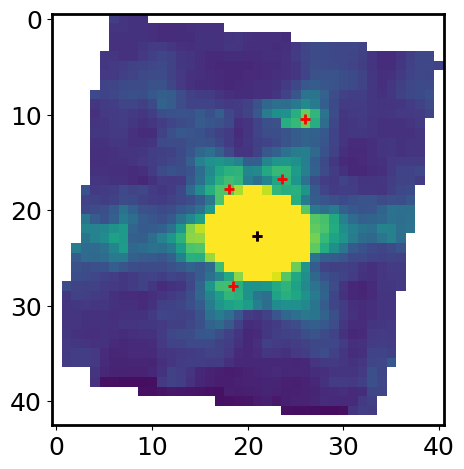

In [10]:
# If you run your own simulations, you will need to update these hardcoded files.
l_cube_file = 'det_image_seq1_MIRIFULONG_34SHORTexp1120546_s3d.fits'
s_cube_file = 'det_image_seq1_MIRIFUSHORT_12LONGexp1125354_s3d.fits'

with fits.open(s_cube_file) as hdu_s_cube:
    s_cube = hdu_s_cube['SCI'].data
    s_med_cube = np.nanmedian(s_cube, axis=0)

mean, median, std = sigma_clipped_stats(s_med_cube, sigma = 2.0)

# Get a list of sources using a dedicated source detection algorithm
# Find sources at least 3* background (typically)

daofind = DAOStarFinder(fwhm = 2.0, threshold = 3. * std)
sources = daofind(s_med_cube - median) 
print("\n Number of sources in field: ", len(sources))

# Positions in pixels
positions = Table([sources['xcentroid'], sources['ycentroid']])

# Convert to RA & Dec (ICRS)
peakpixval = np.zeros(len(sources['xcentroid']))
for count_s, _ in enumerate(sources):
    peakpixval[count_s] = s_med_cube[int(np.round(sources['xcentroid'][count_s])), int(np.round(sources['ycentroid'][count_s]))]
print('peak pixel x =')
print(sources['xcentroid'][np.argmax(peakpixval)])
print('peak pixel y =')
print(sources['ycentroid'][np.argmax(peakpixval)])

plt.imshow(s_med_cube, vmin=0, vmax=100)#.value)
plt.tight_layout()
plt.scatter(sources['xcentroid'], sources['ycentroid'], c = "red", marker = "+", s=50)
plt.scatter(sources['xcentroid'][np.argmax(peakpixval)], sources['ycentroid'][np.argmax(peakpixval)], c = 'black', marker='+', s=50)
plt.show()

f0 = fits.open(s_cube_file)
w0 = WCS(f0[('sci',1)].header, f0)
f0.close()

radec = w0.all_pix2world([sources['xcentroid'][np.argmax(peakpixval)]], [sources['ycentroid'][np.argmax(peakpixval)]], [1], 1)

# Take the brightest source flux and take that to be your primary point source for extraction
ra_ptsrc = radec[0][0]
dec_ptsrc = radec[1][0]

In [11]:
# Due to the way the pipeline currently extracts Level3 data, you must update the headers to be centered on the point source of your choosing from the step above.
all_files = glob.glob('det_image_*_cal.fits')
targra = ra_ptsrc
targdec = dec_ptsrc
for thisfile in all_files:
    base, remainder = thisfile.split('.')
    outfilename = base + '_fix.' + remainder
    print(outfilename)
    
    with fits.open(thisfile) as hduthis:
        hduthis['SCI'].header['SRCTYPE'] = 'POINT'
        hduthis[0].header['TARG_RA'] = targra
        hduthis[0].header['TARG_DEC'] = targdec
        hduthis.writeto(outfilename, overwrite=True)

det_image_seq2_MIRIFULONG_34LONGexp1125354_cal_fix.fits
det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_cal_fix.fits
det_image_seq4_MIRIFUSHORT_12LONGexp1125354_cal_fix.fits
det_image_seq4_MIRIFULONG_34SHORTexp1120546_cal_fix.fits
det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_cal_fix.fits
det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_cal_fix.fits
det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_cal_fix.fits
det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_cal_fix.fits
det_image_seq2_MIRIFULONG_34SHORTexp1120546_cal_fix.fits
det_image_seq3_MIRIFUSHORT_12MEDIUMexp1123047_cal_fix.fits
det_image_seq1_MIRIFULONG_34LONGexp1125354_cal_fix.fits
det_image_seq4_MIRIFULONG_34LONGexp1125354_cal_fix.fits
det_image_seq1_MIRIFUSHORT_12LONGexp1125354_cal_fix.fits
det_image_seq4_MIRIFUSHORT_12SHORTexp1120546_cal_fix.fits
det_image_seq2_MIRIFUSHORT_12MEDIUMexp1123047_cal_fix.fits
det_image_seq3_MIRIFUSHORT_12LONGexp1125354_cal_fix.fits
det_image_seq2_MIRIFUSHORT_12LONGexp1125354_cal_fix.fits
det_image_seq4_MIRIFULON

In [12]:
# set up needed reference file(s) for spec3

file_all_list = glob.glob('det_image_*_cal_fix.fits')

asnall = asn_from_list.asn_from_list(file_all_list, rule=DMS_Level3_Base, product_name='combine_dithers_all_exposures')

asnallfile = 'for_spec3_all.json'
with open(asnallfile, 'w') as fpall:
    fpall.write(asnall.dump()[1])

In [13]:
# Execute calwebb_spec3 pipeline.  This will overwrite previous reductions.

pipe3ss = Spec3Pipeline()
pipe3ss.master_background.skip = True
pipe3ss.mrs_imatch.skip = True
pipe3ss.outlier_detection.skip = True
pipe3ss.resample_spec.skip = True
pipe3ss.combine_1d.skip = True
pipe3ss.use_source_posn = 'True'
pipe3ss.subtract_background = 'True'
pipe3ss.output_file = 'allspec3'
pipe3ss.run(asnallfile)

2023-09-20 19:42:14,711 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_apcorr_0002.asdf  432.8 K bytes  (1 / 2 files) (0 / 683.5 K bytes)
2023-09-20 19:42:15,147 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/miri/jwst_miri_extract1d_0003.asdf  250.7 K bytes  (2 / 2 files) (432.8 K / 683.5 K bytes)


## Next Step

Proceed to Notebook 2 for visualization and data anlysis.

## Additional Resources

- [PampelMuse](https://gitlab.gwdg.de/skamann/pampelmuse)
- [CASA](https://casa.nrao.edu/Release3.4.0/docs/UserMan/UserManse41.html)

## About this notebook
**Author:** Olivia Jones, Project Scientist, UK ATC.
**Updated On:** 2020-08-11
**Later Updated On:** 2021-09-06 by B. Sargent, STScI Scientist, Space Telescope Science Institute

***

[Top of Page](#top)